# **TEST POUR 20 CLUSTERS**

In [11]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [12]:
# ==========
# 1) Paramètres
# ==========
INPUT_CSV = "../DATAS/ANSTAT2021_dataset_Clean.csv"
OUTPUT_CLUSTERS_CSV = "../DATAS/ANSTAT2021_clusters_20.csv"
OUTPUT_PROFILES_CSV = "../DATAS/ANSTAT2021_cluster_profiles_20.csv"
RANDOM_STATE = 42
K_MIN, K_MAX = 2, 20   # plage testée pour k


In [13]:

# ==========
# 2) Chargement
# ==========
df = pd.read_csv(INPUT_CSV)
print(f"✅  Chargé : {INPUT_CSV} | shape={df.shape}")


✅  Chargé : ../DATAS/ANSTAT2021_dataset_Clean.csv | shape=(64474, 70)


In [14]:

# ==========
# 3) Variables pour le clustering
#    Démarrage = variables communes (cohérence inter-bases)
# ==========
num_vars = [
    "age_num",
    #"rev_total_mois",
]

# sex / marital_status / city / bancarise / milieu_resid / region_name existent souvent,
# mais on choisit ici un noyau minimal robuste (communes & stables)
cat_vars = [
    "sex",
    "marital_status",
    "city",
    #'milieu_resid',
    'region_name',
    "bancarise",
]

# Sélection défensive (au cas où certaines colonnes n’existent pas)
present_num = [c for c in num_vars if c in df.columns]
present_cat = [c for c in cat_vars if c in df.columns]
features = present_num + present_cat
if not features:
    raise ValueError("Aucune variable pertinente trouvée pour le clustering.")

X = df[features].copy()


In [15]:

# ==========
# 4) Prétraitements
#    - Imputation (num: médiane, cat: le plus fréquent)
#    - Encodage One-Hot pour catégorielles
#    - Standardisation pour numériques
# ==========
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, present_num),
        ("cat", cat_pipe, present_cat),
    ],
    remainder="drop",
)


🔎  Silhouette scores:
  k=2: 0.2442
  k=3: 0.1535
  k=4: 0.1470
  k=5: 0.1471
  k=6: 0.1510
  k=7: 0.1534
  k=8: 0.1158
  k=9: 0.1136
  k=10: 0.1112
  k=11: 0.1142
  k=12: 0.0809
  k=13: 0.0870
  k=14: 0.0883
  k=15: 0.0893
  k=16: 0.0849
  k=17: 0.0855
  k=18: 0.0885
  k=19: 0.0876
  k=20: 0.0884

🔎  SSE (inertia) values:
  k=2: 208113.14
  k=3: 188131.72
  k=4: 174438.34
  k=5: 166240.86
  k=6: 160544.14
  k=7: 154112.75
  k=8: 152104.11
  k=9: 150698.72
  k=10: 148875.69
  k=11: 146368.67
  k=12: 144484.46
  k=13: 142811.55
  k=14: 141752.81
  k=15: 138743.16
  k=16: 137256.84
  k=17: 136539.89
  k=18: 135792.33
  k=19: 133789.98
  k=20: 133037.38

🏆  Meilleur k = 2 (silhouette=0.2442)


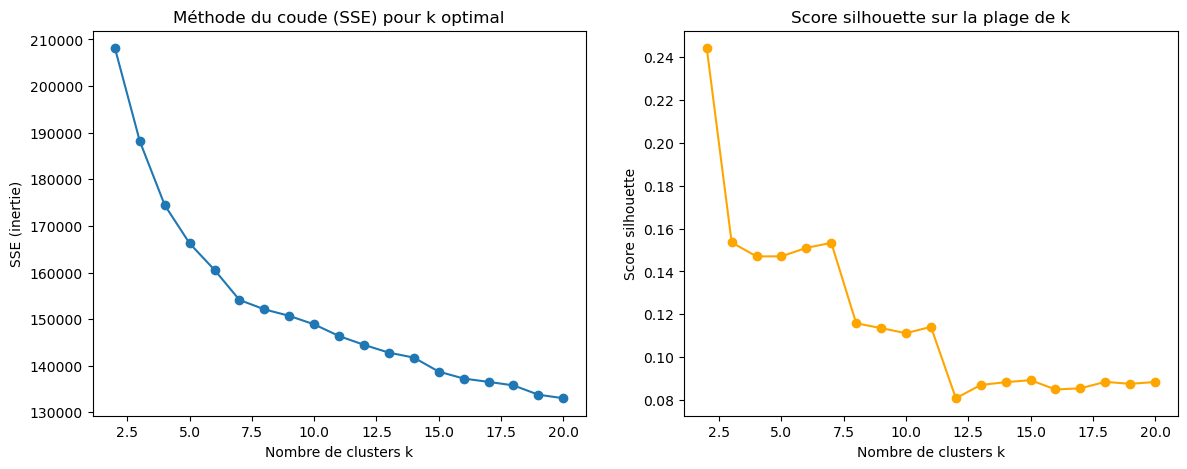

In [16]:

# ==========
# 5) Recherche du meilleur k (SSE + silhouette)
# ==========

X_prepared = preprocess.fit_transform(X)

best_k = None
best_score = -1
scores = []
sse_values = []

for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
    labels = km.fit_predict(X_prepared)
    score = silhouette_score(X_prepared, labels)
    sse = km.inertia_
    scores.append((k, score))
    sse_values.append((k, sse))
    if score > best_score:
        best_k, best_score = k, score

print("🔎  Silhouette scores:")
for k, s in scores:
    print(f"  k={k}: {s:.4f}")

print("\n🔎  SSE (inertia) values:")
for k, sse in sse_values:
    print(f"  k={k}: {sse:.2f}")

print(f"\n🏆  Meilleur k = {best_k} (silhouette={best_score:.4f})")

# Visualisation méthode du coude et silhouette
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot([k for k, _ in sse_values], [sse for _, sse in sse_values], marker='o')
plt.title("Méthode du coude (SSE) pour k optimal")
plt.xlabel("Nombre de clusters k")
plt.ylabel("SSE (inertie)")

plt.subplot(1, 2, 2)
plt.plot([k for k, _ in scores], [score for _, score in scores], marker='o', color='orange')
plt.title("Score silhouette sur la plage de k")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Score silhouette")

plt.show()


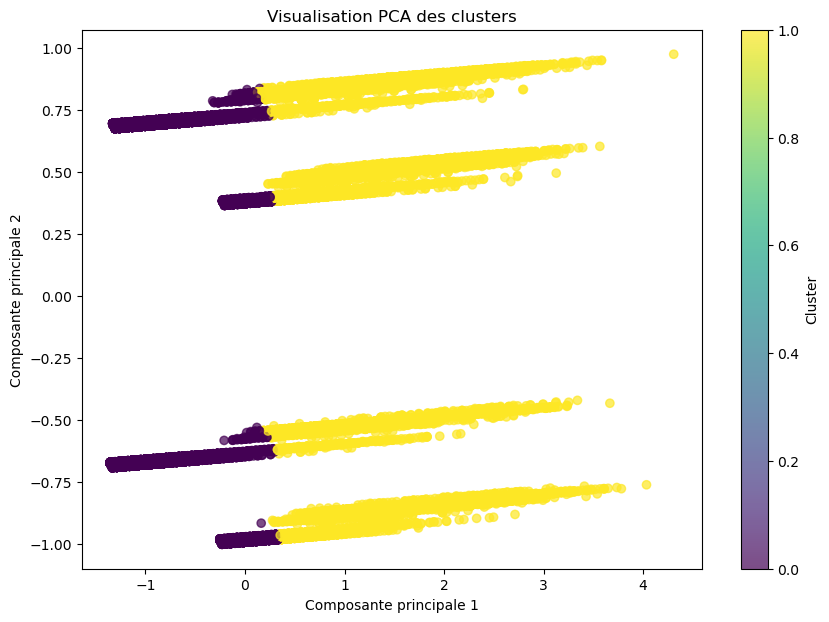

In [17]:

# ==========
# 6) Entraînement final avec best_k + affectation des clusters
# ==========

final_km = KMeans(n_clusters=best_k, n_init="auto", random_state=RANDOM_STATE)
clusters = final_km.fit_predict(X_prepared)
df["cluster"] = clusters

# ==========
# 6b) Visualisation PCA des clusters
# ==========

# PCA 2 composantes pour visualiser la séparation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prepared)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("Visualisation PCA des clusters")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()


In [18]:

# ==========
# 7) Profils de clusters (métriques utiles)
#    - Taille, médianes numériques, % par modalités clés
# ==========
profiles = []

def pct_true(s):
    # gère 0/1 ou Oui/Non si déjà encodé en bool
    if s.dtype == "bool":
        return float(np.mean(s)) * 100.0
    # essaie de convertir 0/1
    try:
        arr = s.astype(float)
        return float(np.mean(arr)) * 100.0
    except Exception:
        return np.nan

for c in sorted(df["cluster"].unique()):
    sub = df[df["cluster"] == c]
    row = {
        "cluster": c,
        "taille": len(sub),
        "age_median": sub["age_num"].median() if "age_num" in sub else np.nan,
        #"revenu_median": sub["rev_total_mois"].median() if "rev_total_mois" in sub else np.nan,
    }
    # % bancarisés si dispo
    if "bancarise" in sub.columns:
        # bancarise peut être 0/1
        row["pct_bancarisés"] = pct_true(sub["bancarise"])
    # répartition milieu/region (top 1)
    if "region_name" in sub.columns:
        row["region_mode"] = sub["region_name"].mode(dropna=True).iloc[0] if not sub["region_name"].mode(dropna=True).empty else np.nan
        
    if "city" in sub.columns:
        row["ville_mode"] = sub["city"].mode(dropna=True).iloc[0] if not sub["city"].mode(dropna=True).empty else np.nan  
    if "marital_status" in sub.columns:
        row["statut_matrimonial_mode"] = sub["marital_status"].mode(dropna=True).iloc[0] if not sub["marital_status"].mode(dropna=True).empty else np.nan
    if "sex" in sub.columns:
        row["sexe_mode"] = sub["sex"].mode(dropna=True).iloc[0] if not sub["sex"].mode(dropna=True).empty else np.nan

    profiles.append(row)

profiles_df = pd.DataFrame(profiles).sort_values("cluster").reset_index(drop=True)


In [19]:
# ==========
# 8) Exports
# ==========
df_out_cols = ["cluster"] + features  # export léger : cluster + features d'entrée
df_out = df[df_out_cols].copy()
df_out.to_csv(OUTPUT_CLUSTERS_CSV, index=False, encoding="utf-8")
profiles_df.to_csv(OUTPUT_PROFILES_CSV, index=False, encoding="utf-8")

print(f"💾  Export affectations: {OUTPUT_CLUSTERS_CSV}  (shape={df_out.shape})")
print(f"💾  Export profils:      {OUTPUT_PROFILES_CSV} (shape={profiles_df.shape})")


💾  Export affectations: ../DATAS/ANSTAT2021_clusters_20.csv  (shape=(64474, 7))
💾  Export profils:      ../DATAS/ANSTAT2021_cluster_profiles_20.csv (shape=(2, 8))


In [20]:


# ==========
# 9) Affichage console des profils
# ==========
with pd.option_context("display.max_columns", None):
    print("\n=== PROFILS DE CLUSTERS ===")
    print(profiles_df)




=== PROFILS DE CLUSTERS ===
   cluster  taille  age_median  pct_bancarisés         region_mode ville_mode  \
0        0   39116         9.0        8.886389  AUTONOME D'ABIDJAN    ABIDJAN   
1        1   25358        41.0       54.286616  AUTONOME D'ABIDJAN    ABIDJAN   

  statut_matrimonial_mode sexe_mode  
0             Célibataire  Masculin  
1                Marié(e)   Féminin  
